# 第12回ハンズオン: NumPyによる2層ニューラルネットワーク（コメント強化版）

このノートブックでは、NumPyを使って2層のニューラルネットワーク（多層パーセプトロン）を自作し、分類タスク（手書き数字データ）に対して学習・評価を行います。

- 活性化関数: sigmoid
- 損失関数: 二乗誤差
- 学習手法: ミニバッチSGD

In [1]:
# 必要なライブラリを読み込み
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

In [2]:
# 手書き数字データ（0〜9）を読み込み、one-hotエンコードでラベルを整形
X, y = load_digits(return_X_y=True)
y = y.reshape(-1, 1)
enc = OneHotEncoder(sparse_output=False)
y_onehot = enc.fit_transform(y)
# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.3, random_state=42)
# 入力データは16で正規化（画素値が0〜16なので）
X_train = X_train / 16.0
X_test = X_test / 16.0

In [3]:
# シグモイド関数とその導関数（逆伝播で使用）
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def sigmoid_deriv(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [4]:
# 重みとバイアスの初期化（ランダム）
np.random.seed(42)
in_dim, hidden_dim, out_dim = X_train.shape[1], 64, y_train.shape[1]
W1 = np.random.randn(in_dim, hidden_dim) * 0.1  # 入力層 -> 隠れ層
b1 = np.zeros((1, hidden_dim))
W2 = np.random.randn(hidden_dim, out_dim) * 0.1  # 隠れ層 -> 出力層
b2 = np.zeros((1, out_dim))

In [8]:
# 学習パラメータ設定
lr = 0.1
epochs = 500
batch_size = 32
losses = []

# 学習ループ
for epoch in range(epochs):
    # データをシャッフル
    indices = np.random.permutation(X_train.shape[0])
    X_shuffled = X_train[indices]
    y_shuffled = y_train[indices]
    for i in range(0, X_train.shape[0], batch_size):
        # ミニバッチ取得
        Xb = X_shuffled[i:i+batch_size]
        yb = y_shuffled[i:i+batch_size]
        # 順伝播
        z1 = Xb @ W1 + b1
        a1 = sigmoid(z1)
        z2 = a1 @ W2 + b2
        a2 = sigmoid(z2)
        # 損失（二乗誤差）
        loss = np.mean((a2 - yb) ** 2)
        # 逆伝播
        dz2 = (a2 - yb) * sigmoid_deriv(z2)
        dW2 = a1.T @ dz2
        db2 = np.sum(dz2, axis=0, keepdims=True)
        dz1 = dz2 @ W2.T * sigmoid_deriv(z1)
        dW1 = Xb.T @ dz1
        db1 = np.sum(dz1, axis=0, keepdims=True)
        # 重み更新（SGD）
        W2 -= lr * dW2 / batch_size
        b2 -= lr * db2 / batch_size
        W1 -= lr * dW1 / batch_size
        b1 -= lr * db1 / batch_size
    # エポックごとの損失を記録
    losses.append(loss)
print("最終ロス:", losses[-1])

最終ロス: 0.006653498718265659


In [9]:
# テストデータに対する精度評価
a1 = sigmoid(X_test @ W1 + b1)
a2 = sigmoid(a1 @ W2 + b2)
y_pred = np.argmax(a2, axis=1)
y_true = np.argmax(y_test, axis=1)
print("テスト精度:", accuracy_score(y_true, y_pred))

テスト精度: 0.9629629629629629


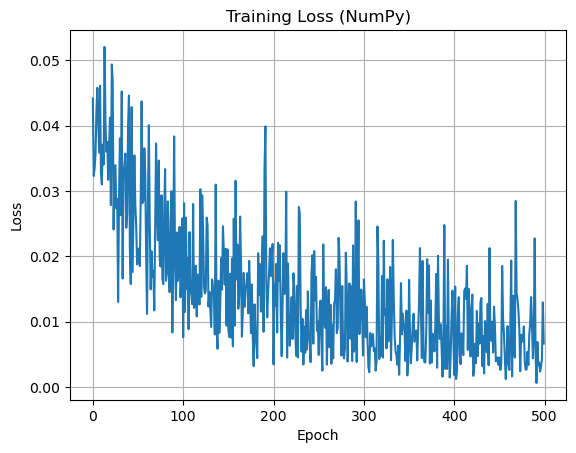

In [10]:
# ロスの推移を可視化
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss (NumPy)')
plt.grid(True)
plt.show()